In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

### Multiclass classifier 1X2

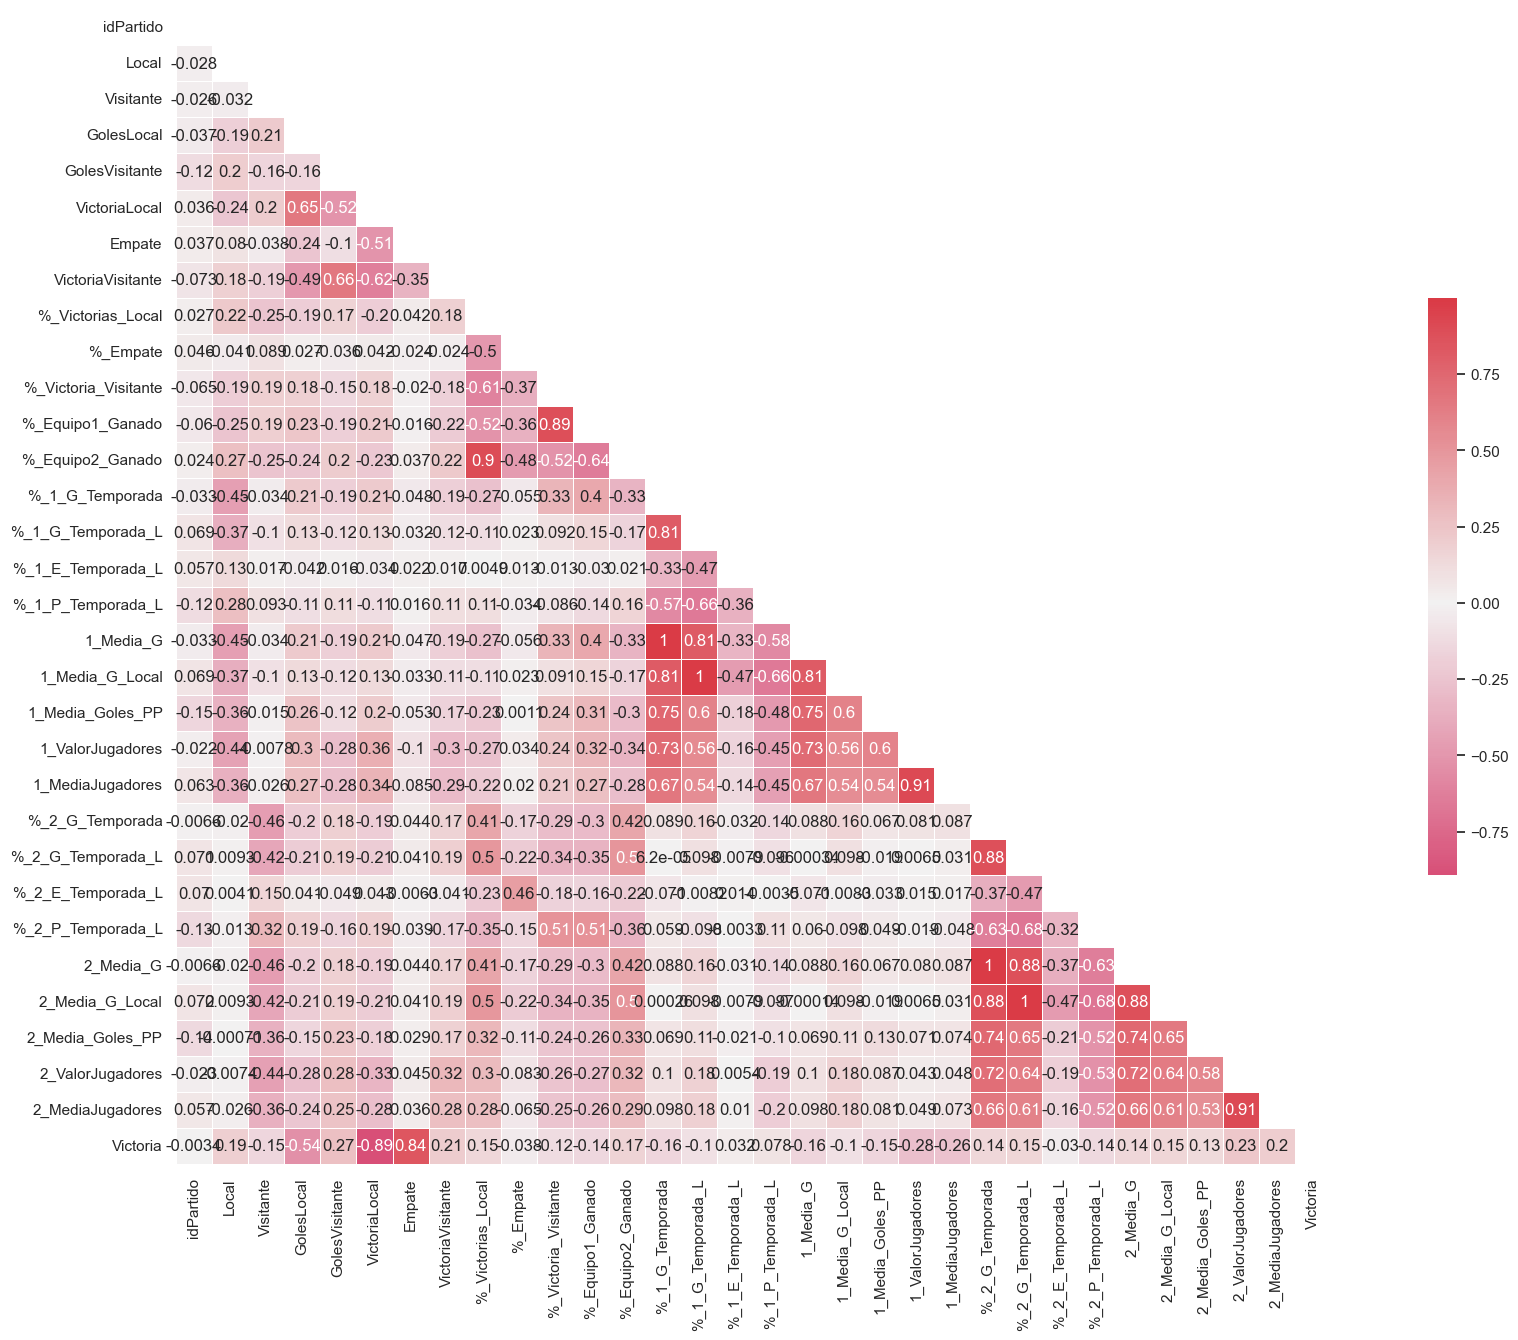

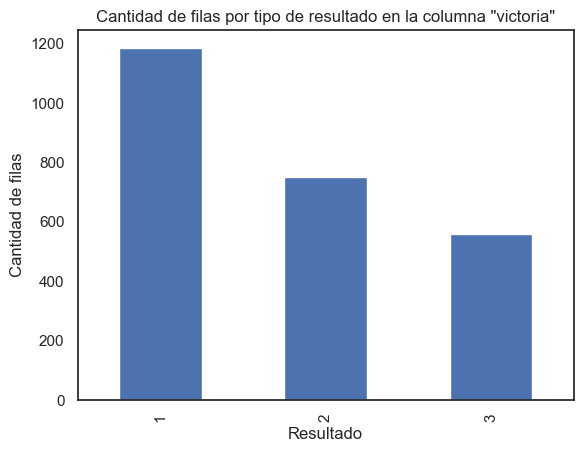

x_train: (1745, 25)


In [2]:
class Data:
    def __init__(self, file_path):
        self.file_path = file_path

    def load_data(self):
        data = pd.read_csv(self.file_path)
        return data

    def preprocess_data(self, data):
        data['Victoria'] = data.apply(
            lambda row: 1 if row['VictoriaLocal'] == 1 else (3 if row['Empate'] == 1 else 2), axis=1)

    def explore_data(self, data):
        columnas_numericas = data.select_dtypes(include='number')
        matriz_correlacion = columnas_numericas.corr()
        plt.figure(figsize=(25, 15))
        sns.set(style='white')
        mask = np.triu(np.ones_like(matriz_correlacion, dtype=bool))
        cmap = sns.diverging_palette(0, 10, as_cmap=True)
        sns.heatmap(matriz_correlacion,
                    mask=mask,
                    cmap=cmap,
                    center=0,
                    square=True,
                    annot=True,
                    linewidths=0.5,
                    cbar_kws={'shrink': 0.5})
        plt.show()
        victoria_counts = data['Victoria'].value_counts()
        victoria_counts.plot(kind='bar')
        plt.xlabel('Resultado')
        plt.ylabel('Cantidad de filas')
        plt.title('Cantidad de filas por tipo de resultado en la columna "victoria"')
        plt.show()
        return victoria_counts  

    def prepare_data(self, data):
        X = data.drop(['idPartido', 'Ronda', 'Temporada', 'Evento', 'Victoria', 'GolesLocal', 'GolesVisitante', 'VictoriaLocal', 'VictoriaVisitante', 'Empate'], axis=1).columns
        y = 'Victoria'
        partidos_X = data[X].values
        partidos_y = data[y].values
        x_train, x_test, y_train, y_test = train_test_split(partidos_X, partidos_y, test_size=0.30, random_state=0, stratify=partidos_y)
        print('x_train:', x_train.shape)
        return x_train, x_test, y_train, y_test, X, y
    
data = Data('../dataframe/champions.csv')
df = data.load_data()
data.preprocess_data(df)
data.explore_data(df)
x_train, x_test, y_train, y_test, X, y = data.prepare_data(df)


### Modelos

In [3]:
class Model:
    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

    def train_logistic_regression(self):
        pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                                   ('regressor', LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=10000))])
        logistic_regression_model = pipeline.fit(self.x_train, self.y_train)
        return logistic_regression_model

    def train_random_forest(self):
        pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                                   ('regressor', RandomForestClassifier(n_estimators=100, random_state=42))])
        random_forest_model = pipeline.fit(self.x_train, self.y_train)
        return random_forest_model

    def train_gradient_boosting(self):
        pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                                   ('regressor', GradientBoostingClassifier(random_state=42))])
        gradient_boosting_model = pipeline.fit(self.x_train, self.y_train)
        return gradient_boosting_model

    def train_support_vector_machine(self):
        columnas_a_escalar = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
        feature_transformer = Pipeline(steps=[('scaler', StandardScaler())])
        preprocessor = ColumnTransformer(transformers=[('preprocess', feature_transformer, columnas_a_escalar)])

        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('regressor', SVC(decision_function_shape='ovr', probability=True, random_state=42))])
        
        SVM_model = pipeline.fit(self.x_train, self.y_train)
        return SVM_model


model = Model(x_train, x_test, y_train, y_test)
LR_model = model.train_logistic_regression()
GB_model = model.train_gradient_boosting()
RF_model = model.train_random_forest()
SVM_model = model.train_support_vector_machine()

### Métricas de evaluación del modelo

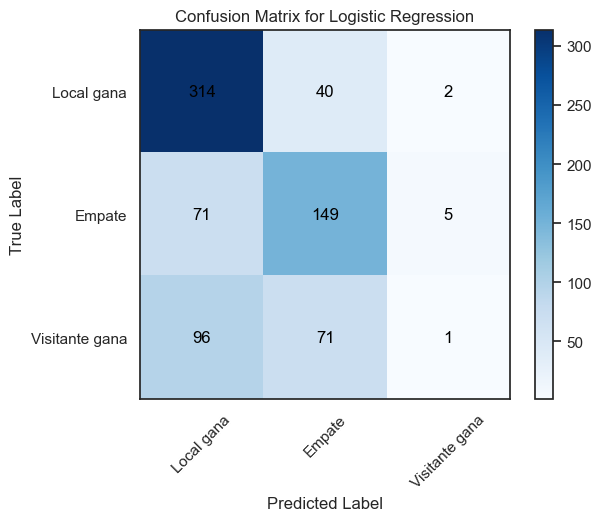

/Users/carlotasanchezgonzalez/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


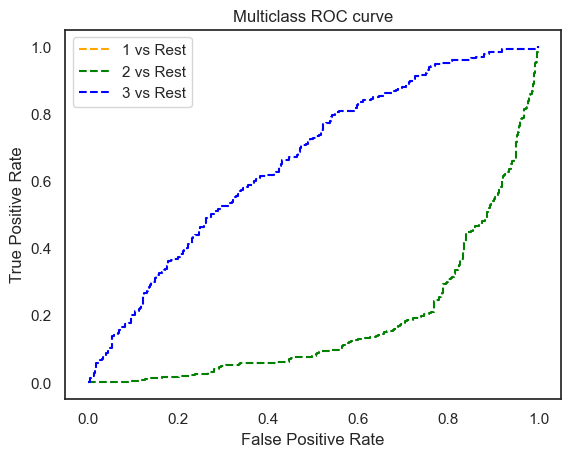

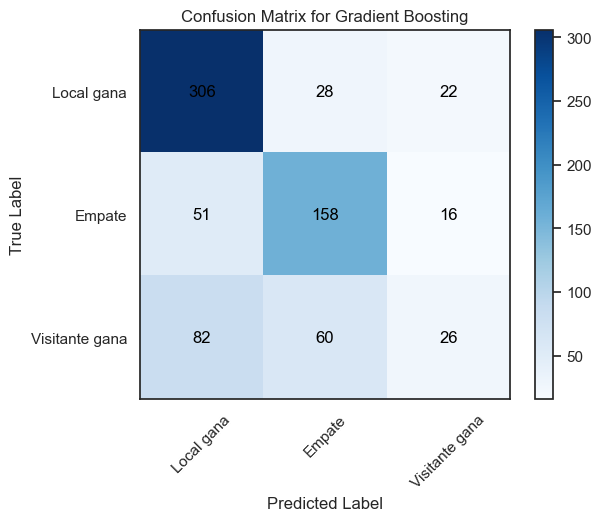

/Users/carlotasanchezgonzalez/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


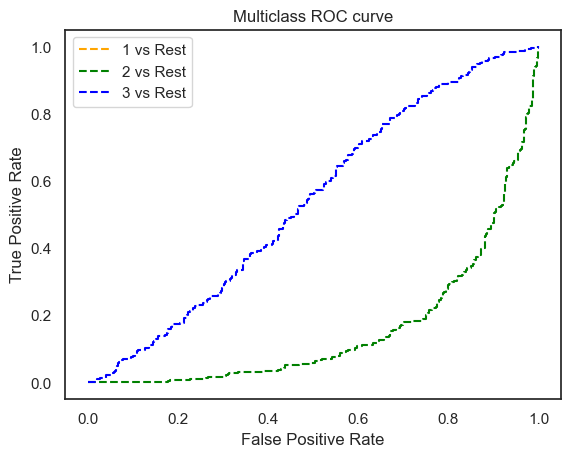

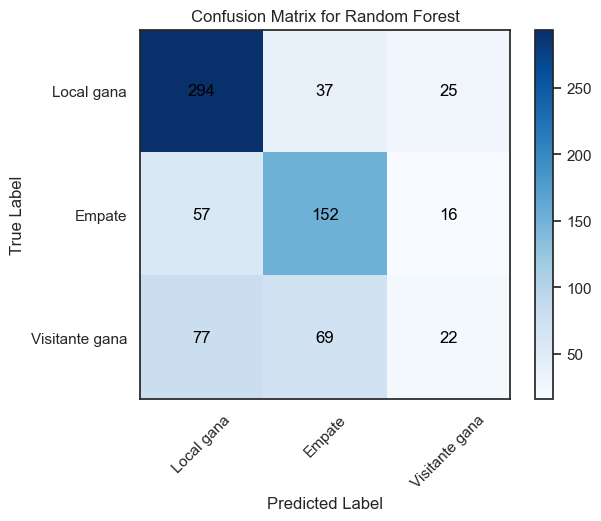

/Users/carlotasanchezgonzalez/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


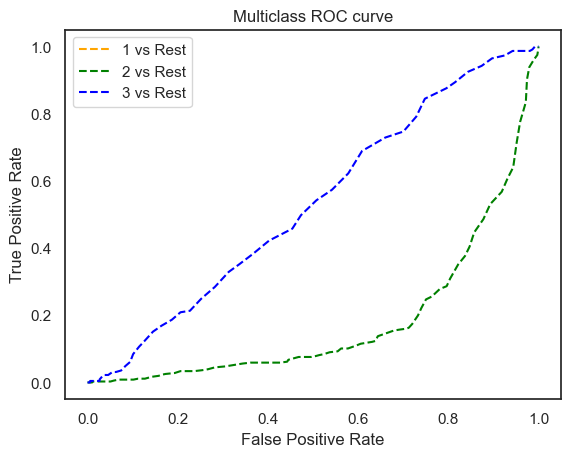

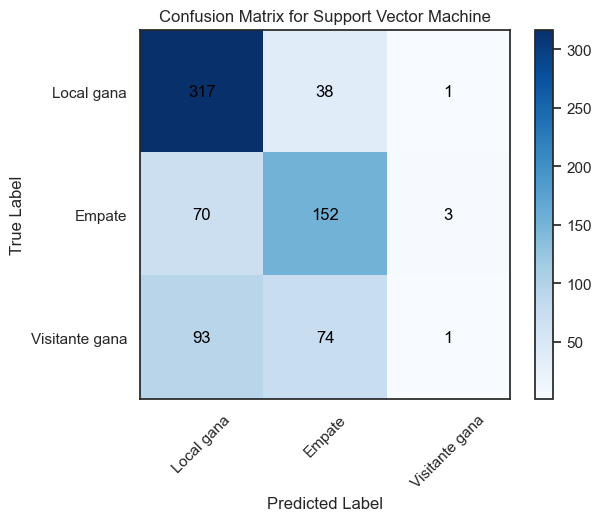

/Users/carlotasanchezgonzalez/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


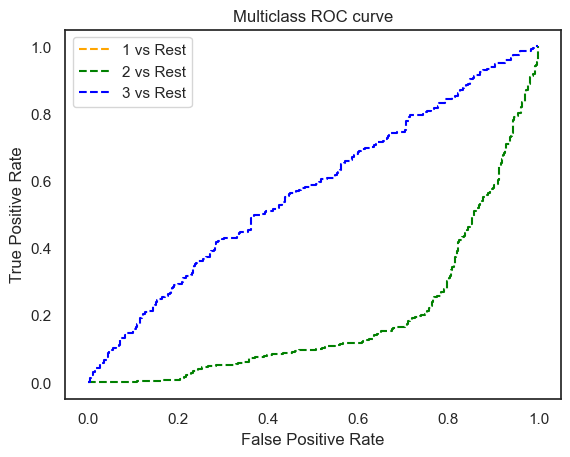

In [4]:
class Evaluation:
    def __init__(self, model, x_test, y_test):
        self.model = model
        self.x_test = x_test
        self.y_test = y_test
    
    def evaluate_model(self):
        y_pred = self.model.predict(self.x_test)
        accuracy = accuracy_score(self.y_test, y_pred)
        precision = precision_score(self.y_test, y_pred, average='weighted')
        recall = recall_score(self.y_test, y_pred, average='weighted')
        auc = roc_auc_score(self.y_test, y_pred, average='weighted', multi_class='ovr')
        confusion = confusion_matrix(self.y_test, y_pred)
        report = classification_report(self.y_test, y_pred)
        print("Model:", model)
        print("Overall Accuracy:", accuracy)
        print("Overall Precision:", precision)
        print("Overall Recall:", recall)
        print("Average AUC:", auc)
        return accuracy, precision, recall, confusion, report
    
    def plot(self, model_name):
        y_pred = self.model.predict(self.x_test)  # Obtener las predicciones del modelo
        conf_matrix = confusion_matrix(self.y_test, y_pred)
        plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
        plt.colorbar()
        plt.xticks(np.arange(len(conf_matrix)), ['Local gana', 'Empate', 'Visitante gana'], rotation=45)
        plt.yticks(np.arange(len(conf_matrix)), ['Local gana', 'Empate', 'Visitante gana'])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix for " + model_name)

        # Agregar los números dentro de los cuadraditos de la matriz de confusión
        for i in range(len(conf_matrix)):
            for j in range(len(conf_matrix[0])):
                plt.text(j, i, str(conf_matrix[i, j]), ha="center", va="center", color="black")

        plt.show()

        # Obtener las probabilidades de clase
        partidos_prob = self.model.predict_proba(self.x_test)

        # Obtener métricas ROC para cada clase
        fpr = {}
        tpr = {}
        thresh = {}
        for i in range(len(self.model.classes_)):    
            fpr[i], tpr[i], thresh[i] = roc_curve(self.y_test, partidos_prob[:, i], pos_label=i)
                
        # Graficar la curva ROC para cada clase vs el resto
        plt.plot(fpr[0], tpr[0], linestyle='--', color='orange', label=str(self.model.classes_[0]) + ' vs Rest')
        plt.plot(fpr[1], tpr[1], linestyle='--', color='green', label=str(self.model.classes_[1]) + ' vs Rest')
        plt.plot(fpr[2], tpr[2], linestyle='--', color='blue', label=str(self.model.classes_[2]) + ' vs Rest')

        plt.title('Multiclass ROC curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='best')  # Agregar leyenda
        plt.show()


evaluation_LR = Evaluation(LR_model, x_test, y_test)
evaluation_GB = Evaluation(GB_model, x_test, y_test)
evaluation_RF = Evaluation(RF_model, x_test, y_test)
evaluation_SVM = Evaluation(SVM_model, x_test, y_test)

#Graficas de evaluacion
evaluation_LR.plot('Logistic Regression')
evaluation_GB.plot('Gradient Boosting')
evaluation_RF.plot('Random Forest')
evaluation_SVM.plot('Support Vector Machine')


In [5]:
'''Evalaución de todos los modelos escalados, ya que tienen mejor rendimiento'''


modelos = {'Logistic Regression': LR_model,
          'Random Forest': RF_model,
          'Gradient Boosting': GB_model,
          'SVM': SVM_model}

# Crear un diccionario para almacenar las métricas de cada modelo
metricas = {}

# Iterar sobre cada modelo
for nombre, modelo in modelos.items():
    # Entrenar el modelo
    modelo.fit(x_train, y_train)
    
    # Realizar predicciones en el conjunto de prueba
    predicciones = modelo.predict(x_test)
    predicciones_proba = modelo.predict_proba(x_test)
    
    # Calcular las métricas
    accuracy = accuracy_score(y_test, predicciones)
    precision = precision_score(y_test, predicciones, average='macro')
    recall = recall_score(y_test, predicciones, average='macro')
    roc_auc = roc_auc_score(y_test, predicciones_proba, multi_class='ovr')
    
    # Almacenar las métricas en el diccionario
    metricas[nombre] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'AUC': roc_auc}

# Crear un DataFrame a partir del diccionario de métricas
df_metricas = pd.DataFrame.from_dict(metricas, orient='index')

# Imprimir el DataFrame
df_metricas

,Accuracy,Precision,Recall,AUC
Logistic Regression,0.619493,0.450295,0.516732,0.745172
Random Forest,0.624833,0.541757,0.544117,0.741846
Gradient Boosting,0.654206,0.581855,0.572178,0.777625
SVM,0.627503,0.478725,0.523986,0.730481


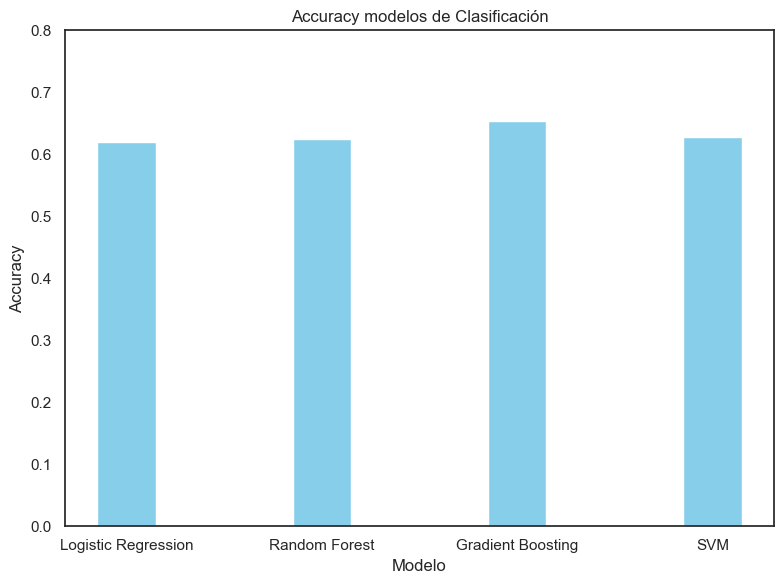

In [6]:
import matplotlib.pyplot as plt

# Extraer los nombres de los modelos y sus accuracies
nombres_modelos = df_metricas.index
accuracies = df_metricas['Accuracy']

# Crear la figura y el eje
plt.figure(figsize=(8, 6))
plt.bar(nombres_modelos, accuracies, color='skyblue', width=0.3)

# Añadir etiquetas y título
plt.xlabel('Modelo')
plt.ylabel('Accuracy')
plt.title('Accuracy modelos de Clasificación')
plt.xticks(rotation=0, ha='center')
plt.ylim(0, 0.8)

# Mostrar el gráfico
plt.tight_layout()
plt.savefig('../resultados/Accuracy_clasificacion.png')

plt.show()

In [7]:
#Voy a guardar los modelos para usarlos para predecir resultados de otros partidos
import joblib

# Guardar los modelos en un archivo
joblib.dump(LR_model, '../modelos/multi_model_LR.pkl')
joblib.dump(RF_model, '../modelos/multi_model_RF.pkl')
joblib.dump(GB_model, '../modelos/multi_model_GB.pkl')
joblib.dump(SVM_model, '../modelos/multi_model_SVC.pkl')


['../modelos/multi_model_SVC.pkl']

In [8]:
#Cargamos los modelos
LR_model = joblib.load('../modelos/multi_model_LR.pkl')
RF_model = joblib.load('../modelos/multi_model_RF.pkl')
GB_model = joblib.load('../modelos/multi_model_GB.pkl')
SVM_model = joblib.load('../modelos/multi_model_SVC.pkl')


In [9]:
# Cargar el nuevo conjunto de datos
data_new = Data('../dataframe/champions_23_24.csv')
df_new = data_new.load_data()

df_new.drop(['idPartido', 'Ronda', 'Temporada', 'Evento', 'GolesLocal', 'GolesVisitante', 'VictoriaLocal', 'VictoriaVisitante', 'Empate'], axis=1, inplace=True)
df_new

,Local,Visitante,%_Victorias_Local,%_Empate,%_Victoria_Visitante,%_Equipo1_Ganado,%_Equipo2_Ganado,%_1_G_Temporada,%_1_G_Temporada_L,%_1_E_Temporada_L,...,1_MediaJugadores,%_2_G_Temporada,%_2_G_Temporada_L,%_2_E_Temporada_L,%_2_P_Temporada_L,2_Media_G,2_Media_G_Local,2_Media_Goles_PP,2_ValorJugadores,2_MediaJugadores
0,2,307,0.00,0.00,100.00,100.00,0.00,40.00,50.0,0.0,...,16.423147,20.00,33.33,0.00,66.67,0.20,0.33,1.20,385.648621,16.767331
1,67,68,100.00,0.00,0.00,0.00,100.00,20.00,50.0,0.0,...,15.543811,42.86,50.00,0.00,50.00,0.43,0.50,1.57,497.803882,21.643647
2,15,20,0.00,0.00,100.00,100.00,0.00,77.78,75.0,0.0,...,29.950970,0.00,0.00,33.33,66.67,0.00,0.00,1.20,374.821246,17.037329
3,28,14,40.00,60.00,0.00,20.00,20.00,36.36,40.0,40.0,...,33.267669,45.45,50.00,50.00,0.00,0.45,0.50,1.36,642.492339,27.934450
4,99,24,100.00,0.00,0.00,0.00,100.00,57.14,100.0,0.0,...,24.959872,55.56,80.00,0.00,20.00,0.56,0.80,2.44,677.936670,30.815303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,3,31,45.45,18.18,36.36,54.55,27.27,54.55,60.0,40.0,...,29.357819,44.44,60.00,20.00,20.00,0.44,0.60,2.11,688.304392,29.926278
120,3,1,46.15,23.08,30.77,23.08,53.85,63.64,80.0,20.0,...,29.357819,72.73,50.00,50.00,0.00,0.73,0.50,2.00,685.444331,31.156560
121,14,28,60.00,40.00,0.00,20.00,40.00,45.45,60.0,40.0,...,27.934450,45.45,50.00,33.33,16.67,0.45,0.50,1.73,698.621042,33.267669
122,28,14,60.00,40.00,0.00,40.00,20.00,45.45,60.0,20.0,...,33.267669,45.45,50.00,50.00,0.00,0.45,0.50,1.36,642.492339,27.934450


In [10]:
# Ahora, puedes usar estos datos preparados para hacer predicciones con tus modelos entrenados
predictions_LR = LR_model.predict(df_new)
predictions_RF = RF_model.predict(df_new)
predictions_GB = GB_model.predict(df_new)
predictions_SVM = SVM_model.predict(df_new)

nuevo_data = df_new.iloc[:, [0, 1]].copy()  # Selecciona las columnas 3 y 4 del DataFrame original
nuevo_data['LR'] = predictions_LR  # Agrega las predicciones como una nueva columna
nuevo_data['RF'] = predictions_RF
nuevo_data['GB'] = predictions_GB
nuevo_data['SVM'] = predictions_SVM

nuevo_data.tail(4)


/Users/carlotasanchezgonzalez/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/carlotasanchezgonzalez/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/carlotasanchezgonzalez/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/carlotasanchezgonzalez/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,Local,Visitante,LR,RF,GB,SVM
120,3,1,1,1,1,1
121,14,28,1,1,1,1
122,28,14,1,1,1,1
123,1,3,1,1,3,1


In [11]:
import json

# Cargar el JSON que contiene la correspondencia entre IDs de equipos y nombres
with open('../dataframe/id_equipo.json', 'r') as f:
    id_equipos = json.load(f)

# Crear un diccionario para facilitar el mapeo
id_to_equipo = {str(value): key for key, value in id_equipos.items()}

In [12]:
# Mapear los IDs de los equipos a sus nombres
nuevo_data['Local'] = nuevo_data['Local'].astype(str).map(id_to_equipo)
nuevo_data['Visitante'] = nuevo_data['Visitante'].astype(str).map(id_to_equipo)
nuevo_data.tail(4)

,Local,Visitante,LR,RF,GB,SVM
120,Bayern München,Real Madrid,1,1,1,1
121,Borussia Dortmund,PSG,1,1,1,1
122,PSG,Borussia Dortmund,1,1,1,1
123,Real Madrid,Bayern München,1,1,3,1
